## Script built to ensure data is being streamed properly

In [1]:
# Import necessary libraries
from multiprocessing import shared_memory
import numpy as np
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces')
from lib_streamAndRenderDataWorkflows.config_streaming import renderingBodyParts
from time import perf_counter
from lib_streamAndRenderDataWorkflows import quaternions
np.set_printoptions(suppress=True)


In [2]:
# Define shared memory

# Define constants
sharedMemName = 'Test Rigid Body'
noDataTypes = 7
noBodyParts = 51

# Initialise the shared memory
sharedMemShape = (noBodyParts,noDataTypes)
sharedMemSize =  noDataTypes * noBodyParts
shared_block = shared_memory.SharedMemory(size= sharedMemSize * 8, name=sharedMemName, create=False)
shared_array = np.ndarray(shape=sharedMemShape, dtype=np.float64, buffer=shared_block.buf)


In [3]:
# Store some functions for calibration

def alertUserForCalibration():
    print('Before we start, the calibration stage must be undertaken')
    print('Face upright and standing towards the computer and point the right hand forward')
    print('Calibration will start in 3')
    time.sleep(1)
    print('2')
    time.sleep(1)
    print('1')
    time.sleep(1)
    print('Calibrating - point your hand and arm forwards and keep it straight')


def calcCalibrationConstants(controlBodyData, calibrationToVector= np.array([1,0,0])):
    """
    attempts to calibrate for person standing off x axis by finding the transformation
    matrix to transform off axis motion to the standard axes
    returns a transformation matrix that can convert directions and positions 
    position is the first three items
    """
    calibrationFromVector = controlBodyData[3:6]
    position = controlBodyData[0:3]
    # calculate thetha from dot product
    thetha_rad = np.arccos(np.dot(calibrationToVector,calibrationFromVector)/(np.linalg.norm(calibrationToVector) * np.linalg.norm(calibrationFromVector)))

    # calculate Q
    Q = np.zeros((3,3))
    Q[0,0] = np.cos(thetha_rad)
    Q[1,1] = Q[0,0]
    Q[0,1] = np.sin(thetha_rad)
    Q[1,0] = - Q[0,1]
    Q[2,2] = 1
    offset = -position

    calibrationMatrix = Q.transpose()
    return calibrationMatrix, offset

def preProcessRawData(sharedData,calibrationMatrix, offset):
    sharedData[:,0:3] = np.matmul(calibrationMatrix,(sharedData[:,0:3] + offset).transpose()).transpose()
    sharedData[:,3:6] = np.matmul(calibrationMatrix,sharedData[:,3:6].transpose()).transpose()
    return sharedData

def findSuitableRange(calibrationMatrix,offset,timeDuration = 10):
    
    # Initialise ranges
    minX = np.inf
    minY = np.inf
    maxX = -np.inf
    maxY = -np.inf

    # Set timestamps
    samplingRate = 120 # in Hz
    timeStamps = np.zeros(samplingRate * timeDuration)
    noTimeStamps = len(timeStamps)

    # Repeat for all times
    for time_ in range(0,noTimeStamps):
        time.sleep(1/samplingRate)
        sharedData = preProcessRawData(sharedData=shared_array.copy(), calibrationMatrix=calibrationMatrix,offset=offset)
        timeStamps[time_] = perf_counter() 
        y = sharedData[27,2]
        x = - sharedData[27,1]
        minX, minY = min(minX,x), min(minY,y)
        maxX, maxY = max(maxX,x), max(maxY,y)
    
    return minX,maxX, minY, maxY

def calcScreenPos(processedData,minX,maxX,minY,maxY):
    return ((-processedData[27,1] - minX) /( maxX - minX)), ((processedData[27,2] - minY) / (maxY - minY))


In [4]:
# Calibrate initial readings
alertUserForCalibration()

# Read shared memory ( right hand is idx 27)
rightHandData = shared_array[27,:]

# Find calibration matrix and offset
calibrationMatrix, offset = calcCalibrationConstants(rightHandData)

print("Calibrated")


Before we start, the calibration stage must be undertaken
Face upright and standing towards the computer and point the right hand forward
Calibration will start in 3
2
1
Calibrating - point your hand and arm forwards and keep it straight
Calibrated


In [5]:
shared_array[8,0:6]

array([-0.31111214,  3.48177338, -0.02077894,  0.46912035,  0.75183499,
        0.46332533])

In [519]:
#This part covers testing how the rotation of the right hand can be used to control position

import math

rotations = np.zeros((1000,3))
angles = np.zeros((1000,2))

for i in range(rotations.shape[0]):
    dz,dx,dy = shared_array[27,3:6]
    rotations[i,:] = shared_array[27,3:6]
    #print(shared_array[8,3:6])

    # Calculate rotation angles
    angleZ = math.atan2(dz, dx)
    angleY = math.atan2(dz,dy)
    #angleX = math.atan2(dy,dz)


    # Convert the angle to degrees
    #angleX = math.degrees(angleX)
    angleY = math.degrees(angleY) # up down
    angleZ = math.degrees(angleZ) # left right

    if angleY < 0:
        angleY += 360
    if angleZ < 0:
        angleZ += 360

    angles[i,:] = angleY,angleZ
    time.sleep(1/120)



/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_24720/1189059833.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("DataAnalysis/RotationPlots/rotations_movingArmCircle.svg")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_24720/1189059833.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("DataAnalysis/RotationPlots/rotations_movingArmCircle.svg")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_24720/1189059833.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("DataAnalysis/RotationPlots/rotations_movingArmCircle.svg")


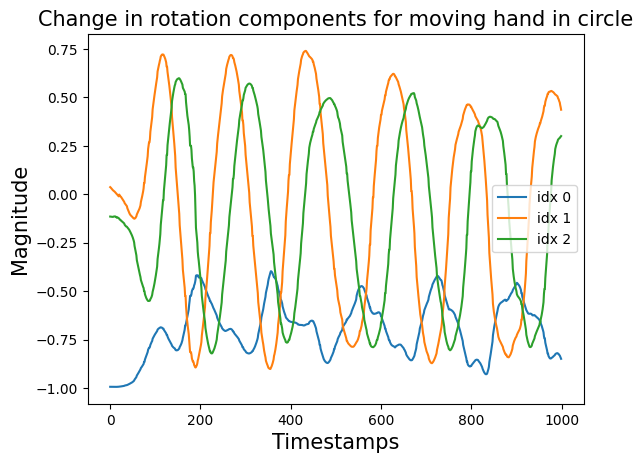

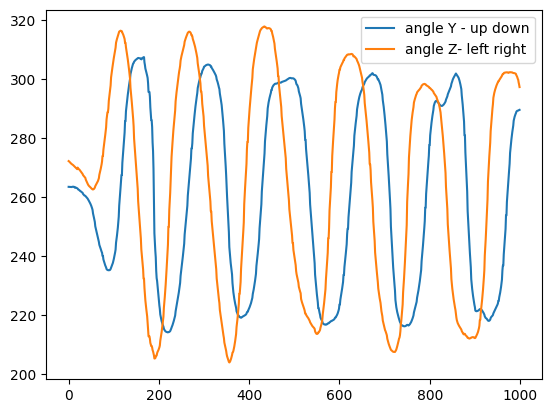

In [520]:


plt.plot(rotations[:,0],label = 'idx 0')
plt.plot(rotations[:,1], label = 'idx 1')# right left
plt.plot(rotations[:,2], label = 'idx 2')# up down
plt.title("Change in rotation components for moving hand in circle", fontsize = 15)
plt.xlabel("Timestamps", fontsize = 15)
plt.ylabel("Magnitude",fontsize = 15)
plt.legend()
plt.savefig("DataAnalysis/RotationPlots/rotations_movingArmCircle.svg")

plt.show()
plt.plot(angles[:,0],label = "angle Y - up down")
plt.plot(angles[:,1],label = "angle Z- left right")
plt.legend()



In [770]:
# Find correct range
minX, maxX, minY, maxY = findSuitableRange(calibrationMatrix,offset,10)


In [771]:
print(minX,maxX,minY,maxY)

-0.5436603560087753 -0.10403892558296927 -0.1561100110411644 0.8283099606633186


In [797]:


# Record Data
print(shared_array[27,:3])
startTime = time.perf_counter() * 1000
sharedData = preProcessRawData(sharedData=shared_array.copy(), calibrationMatrix=calibrationMatrix,offset=offset)
x,y = calcScreenPos(sharedData,minX,maxX,minY,maxY)
print(x,y)
print("Current Time:", time.perf_counter()*1000 - startTime)
print(-sharedData[27,1]) # Z is positive up, y is negative left right

[-2.65833163 -0.44173792 -0.05206326]
0.09614864697938871 0.024476507427587713
Current Time: 0.6479160189628601
-0.5013913502901906


In [798]:
if False:
    # Collect data for 5 minutes 
    samplingRate = 120
    duration = 300
    timeFrames = duration * samplingRate
    timesTrain = np.zeros(timeFrames)
    bodyMovementsTrain = np.zeros((timeFrames,306))
    startTime = time.perf_counter() * 1000
    cursorPositionsTrain = np.zeros((timeFrames,2))

    for time_ in range(timeFrames):
        
        # Note time when loop finished
        passTime = time.perf_counter() * 1000 + 1000/120


        # Fetch data
        sharedData = preProcessRawData(sharedData=shared_array[:,:6].copy(), calibrationMatrix=calibrationMatrix,offset=offset)

        bodyMovementsTrain[time_,:] = sharedData.reshape(1,306)

        # Find screen positions
        x,y = calcScreenPos(sharedData,minX,maxX,minY,maxY)
        cursorPositionsTrain[time_,:] = [x,y]

        # Record time
        timesTrain[time_] = time.perf_counter() * 1000 - startTime

        # Wait until ready to move on
        while time.perf_counter() * 1000 < passTime:
            time.sleep(1/1000)
    simpleBodyParts = [0,1,2,3,4,5,6,7,8,24,25,26,27,43,44,45,47,48,49]
    #bodyMovementsTrain = bodyMovementsTrain.reshape(-1,51,6)[:,simpleBodyParts,:].reshape(-1,114)
    


In [802]:
if False:
    samplingRate = 120
    duration = 60
    timeFrames = duration * samplingRate
    timesTest = np.zeros(timeFrames)
    bodyMovementsTest = np.zeros((timeFrames,306))
    startTime = time.perf_counter() * 1000
    cursorPositionsTest = np.zeros((timeFrames,2))

    for time_ in range(timeFrames):
        
        # Note time when loop finished
        passTime = time.perf_counter() * 1000 + 1000/120


        # Fetch data
        sharedData = preProcessRawData(sharedData=shared_array[:,:6].copy(), calibrationMatrix=calibrationMatrix,offset=offset)

        bodyMovementsTest[time_,:] = sharedData.reshape(1,306)

        # Find screen positions
        x,y = calcScreenPos(sharedData,minX,maxX,minY,maxY)
        cursorPositionsTest[time_,:] = [x,y]

        # Record time
        timesTest[time_] = time.perf_counter() * 1000 - startTime

        # Wait until ready to move on
        while time.perf_counter() * 1000 < passTime:
            time.sleep(1/1000)
    simpleBodyParts = [0,1,2,3,4,5,6,7,8,24,25,26,27,43,44,45,47,48,49]
    bodyMovementsTest = bodyMovementsTest.reshape(-1,51,6)[:,simpleBodyParts,:].reshape(-1,114)

In [812]:
#save all Files
np.savez("trainingDataNoGame.npz", cursorPositionsTrain = cursorPositionsTrain,bodyMovementsTrain = bodyMovementsTrain, timesTrain = timesTrain)
np.savez("testDataNoGame.npz", cursorPositionsTest = cursorPositionsTest,bodyMovementsTest = bodyMovementsTest, timesTest = timesTest)

In [837]:
# Function to convert body movements
simpleBodyParts = [0,1,2,3,4,5,6,7,8,24,25,26,27,43,44,45,47,48,49]
#bodyMovementsTrain = bodyMovementsTrain.reshape(-1,51,6)[:,simpleBodyParts,:].reshape(-1,114)
#bodyMovementsTest = bodyMovementsTest.reshape(-1,51,6)[:,simpleBodyParts,:].reshape(-1,114)
print(bodyMovementsTest.shape)

(7200, 114)


In [839]:
# Perform linear regression
from sklearn import linear_model


# First find decoder A
type = 'A'
idxRightHand = renderingBodyParts.index('RHand') * 6
X_train = np.delete(bodyMovementsTrain,slice(idxRightHand,idxRightHand+6,1),1)
X_test_linear = np.delete(bodyMovementsTest,slice(idxRightHand,idxRightHand+6,1),1)

#Model
regA  = linear_model.LinearRegression().fit(X_train, cursorPositionsTrain)
scoreA = regA.score(X_test_linear ,cursorPositionsTest)


# Next find decoder B
type = 'B'
idxRightHand = renderingBodyParts.index('RHand') * 6
idxRightShoulder = renderingBodyParts.index('RShoulder') * 6
X_train = np.delete(bodyMovementsTrain,slice(idxRightShoulder,idxRightHand+6,1),1)
X_test_linear = np.delete(bodyMovementsTest,slice(idxRightShoulder,idxRightHand+6,1),1)

#Model
regB  = linear_model.LinearRegression().fit(X_train, cursorPositionsTrain)
scoreB = regB.score(X_test_linear ,cursorPositionsTest)

# Next find decoder C
# only  the left hand
type = 'C'
idxLeftHand = renderingBodyParts.index('LHand') * 6
X_train = bodyMovementsTrain[:,idxLeftHand:idxLeftHand+6]
X_test_linear = bodyMovementsTest[:,idxLeftHand:idxLeftHand+6]

#Model
regC  = linear_model.LinearRegression().fit(X_train, cursorPositionsTrain)
scoreC = regC.score(X_test_linear ,cursorPositionsTest) 

#Next find decoder D ( right hand control)
type = 'D'
idxRightHand = renderingBodyParts.index('RHand') * 6
X_train = bodyMovementsTrain[:,idxRightHand:idxRightHand+6]
X_test_linear = bodyMovementsTest[:,idxRightHand:idxRightHand+6]


#Model
regD  = linear_model.LinearRegression().fit(X_train, cursorPositionsTrain)
scoreD = regD.score(X_test_linear ,cursorPositionsTest)

In [840]:
scoreA,scoreB,scoreC,scoreD

(0.9999996838555463, 0.6962528562176624, 0.13245326817411496, 1.0)

In [854]:
def decodeScreenMovements(decoder,reg,sharedData):
    # First process input (i.e. remove unnecessary data)
    simpleBodyParts = [0,1,2,3,4,5,6,7,8,24,25,26,27,43,44,45,47,48,49]
    sharedData = sharedData[simpleBodyParts,:6].reshape(114)
    if decoder == "A":
        idxRightHand = renderingBodyParts.index('RHand') * 6
        sharedData_ = np.delete(sharedData,slice(idxRightHand,idxRightHand+6,1),0)
    elif decoder == "B":
        idxRightHand = renderingBodyParts.index('RHand') * 6
        idxRightShoulder = renderingBodyParts.index('RShoulder') * 6
        sharedData_ = np.delete(sharedData,slice(idxRightShoulder,idxRightHand+6,1),0)
    elif decoder == "C":
        idxLeftHand = renderingBodyParts.index('LHand') * 6
        sharedData_ = sharedData[idxLeftHand:idxLeftHand+6]
    
    elif decoder == "D":
        idxRightHand = renderingBodyParts.index('RHand') * 6
        sharedData_ = sharedData[idxRightHand:idxRightHand+6]

    return reg.predict(sharedData_.reshape(1,-1))[0]


In [860]:
if True:
    # Use decoder
    samplingRate = 120
    decoder = "D"
    reg = regD

    duration = 120
    timeFrames = duration * samplingRate
    timesDecoder = np.zeros(timeFrames)
    bodyMovementsDecoder = np.zeros((timeFrames,306))
    startTime = time.perf_counter() * 1000
    cursorPositionsDecoder = np.zeros((timeFrames,2))

    for time_ in range(timeFrames):
        
        # Note time when loop finished
        passTime = time.perf_counter() * 1000 + 1000/120


        # Fetch data
        sharedData = preProcessRawData(sharedData=shared_array[:,:6].copy(), calibrationMatrix=calibrationMatrix,offset=offset)
        bodyMovementsDecoder[time_,:] = sharedData.reshape(1,306)
        # 
       
        # Find screen positions
        x,y = decodeScreenMovements(decoder,reg,sharedData)
        print(x,y)
        cursorPositionsDecoder[time_,:] = [x,y]

        # Record time
        timesDecoder[time_] = time.perf_counter() * 1000 - startTime

        # Wait until ready to move on
        while time.perf_counter() * 1000 < passTime:
            time.sleep(1/1000)
    simpleBodyParts = [0,1,2,3,4,5,6,7,8,24,25,26,27,43,44,45,47,48,49]
    #bodyMovementsTrain = bodyMovementsTrain.reshape(-1,51,6)[:,simpleBodyParts,:].reshape(-1,114)
    


1.7265318894044392 -0.20250519251943114
1.7265567717768815 -0.2025201781454911
1.7265737439659472 -0.20253147791302015
1.726568192966673 -0.20253719212901775
1.7265983574823793 -0.2025433226124059
1.726582023158297 -0.20254208137873222
1.72657082573535 -0.20255125439832047
1.7265351329118381 -0.20256072258933108
1.7264967319845979 -0.20257850099115673
1.7264292585015606 -0.20260496046019996
1.7263977701589637 -0.20261278628714238
1.7263609824796489 -0.20262488074696247
1.726319257617581 -0.20262891475640185
1.726286544831607 -0.20263048900398792
1.726267314380852 -0.2026513553530017
1.726270807018726 -0.20268016105642808
1.7262668913713024 -0.20270301792041848
1.7262974147394425 -0.20271764025857394
1.7263328003609222 -0.20273100622605975
1.7263802624125364 -0.20273749999735238
1.7264667951112007 -0.20274406188512714
1.726617964371049 -0.20274056523904646
1.7267115037217615 -0.20273951321782305
1.7267878337003186 -0.20273242910368564
1.726806663175408 -0.20273730321640412
1.72686538522

KeyboardInterrupt: 